# **Pneumonia Detection Using Chest Xray Images**

Name - Aljo Kunnathaniyil Shaji

student ID - KUN22601379

Colab Link - https://colab.research.google.com/drive/1-uISujuWz3NclEPNFPkO-N6tP-J6UI55?authuser=0#scrollTo=emaVphTp_vzy

Dataset kaggle Link - https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia



In [ ]:
#import the required libraries
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import pandas as pd
import numpy as np
import cv2
import random
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [ ]:
#Mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Preparing the Data**

In [ ]:
#Load Dataset
Data_path = '/content/drive/MyDrive/chest_xray'

print(os.listdir(Data_path))
classes = os.listdir(Data_path + "/train")
print(classes)

['chest_xray', 'test', 'val', 'train']
['NORMAL', 'PNEUMONIA']


In [ ]:
#Define Hyperparameters

learning_rate = 0.001
num_epochs = 10
batch_size = 64

#Preprocessing Data
TRAIN = 'train'
TEST = 'test'
VAL = 'val'

data_transforms = {
    TRAIN: transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    VAL: transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    TEST: transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
}


In [ ]:
# Create datasets using ImageFolder and apply transformations
image_datasets = {x: datasets.ImageFolder(os.path.join(Data_path, x), data_transforms[x])
                  for x in [TRAIN, VAL, TEST]}

# Create a dictionary of dataloaders for each phase
dataloaders = {
    TRAIN: torch.utils.data.DataLoader(image_datasets[TRAIN], batch_size, shuffle=True),
    VAL: torch.utils.data.DataLoader(image_datasets[VAL], batch_size, shuffle=True),

}

In [ ]:
len(dataloaders[TRAIN])

82

In [ ]:
# Get the sizes of the datasets
dataset_sizes = {
    x: len(image_datasets[x])
    for x in [TRAIN, VAL]
}

# Get the classes from the training dataset
classes = image_datasets[TRAIN].classes

# Get the class names from the training dataset
class_names = image_datasets[TRAIN].classes
print(classes)

['NORMAL', 'PNEUMONIA']


In [ ]:
#Number of training samples
pneumonia_files = os.listdir(Data_path + "/train/PNEUMONIA")
normal_files = os.listdir(Data_path + "/train/NORMAL")
print('No. of training examples for Pneumonia:', len(pneumonia_files))
print('No. of training examples for Normal:', len(normal_files))

No. of training examples for Pneumonia: 3875
No. of training examples for Normal: 1341


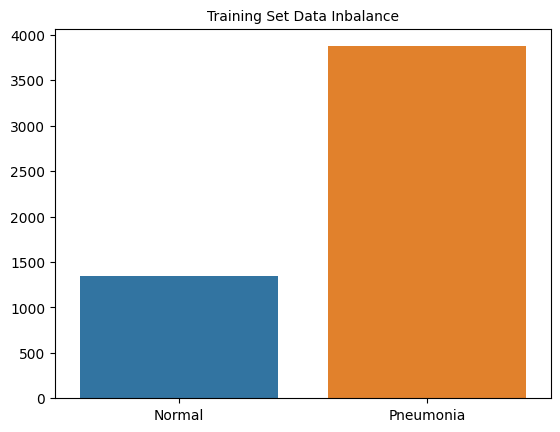

In [ ]:
# plot number of images for each class
train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(Data_path+'/train/NORMAL', filename)
                     for filename in os.listdir(Data_path+'/train/NORMAL')])],
     'Pneumonia': [len([os.path.join(Data_path+'/train/PNEUMONIA', filename)
                        for filename in os.listdir(Data_path+'/train/PNEUMONIA')])]})

sns.barplot(data=train_samplesize).set_title('Training Set Data Inbalance', fontsize=10)
plt.show()

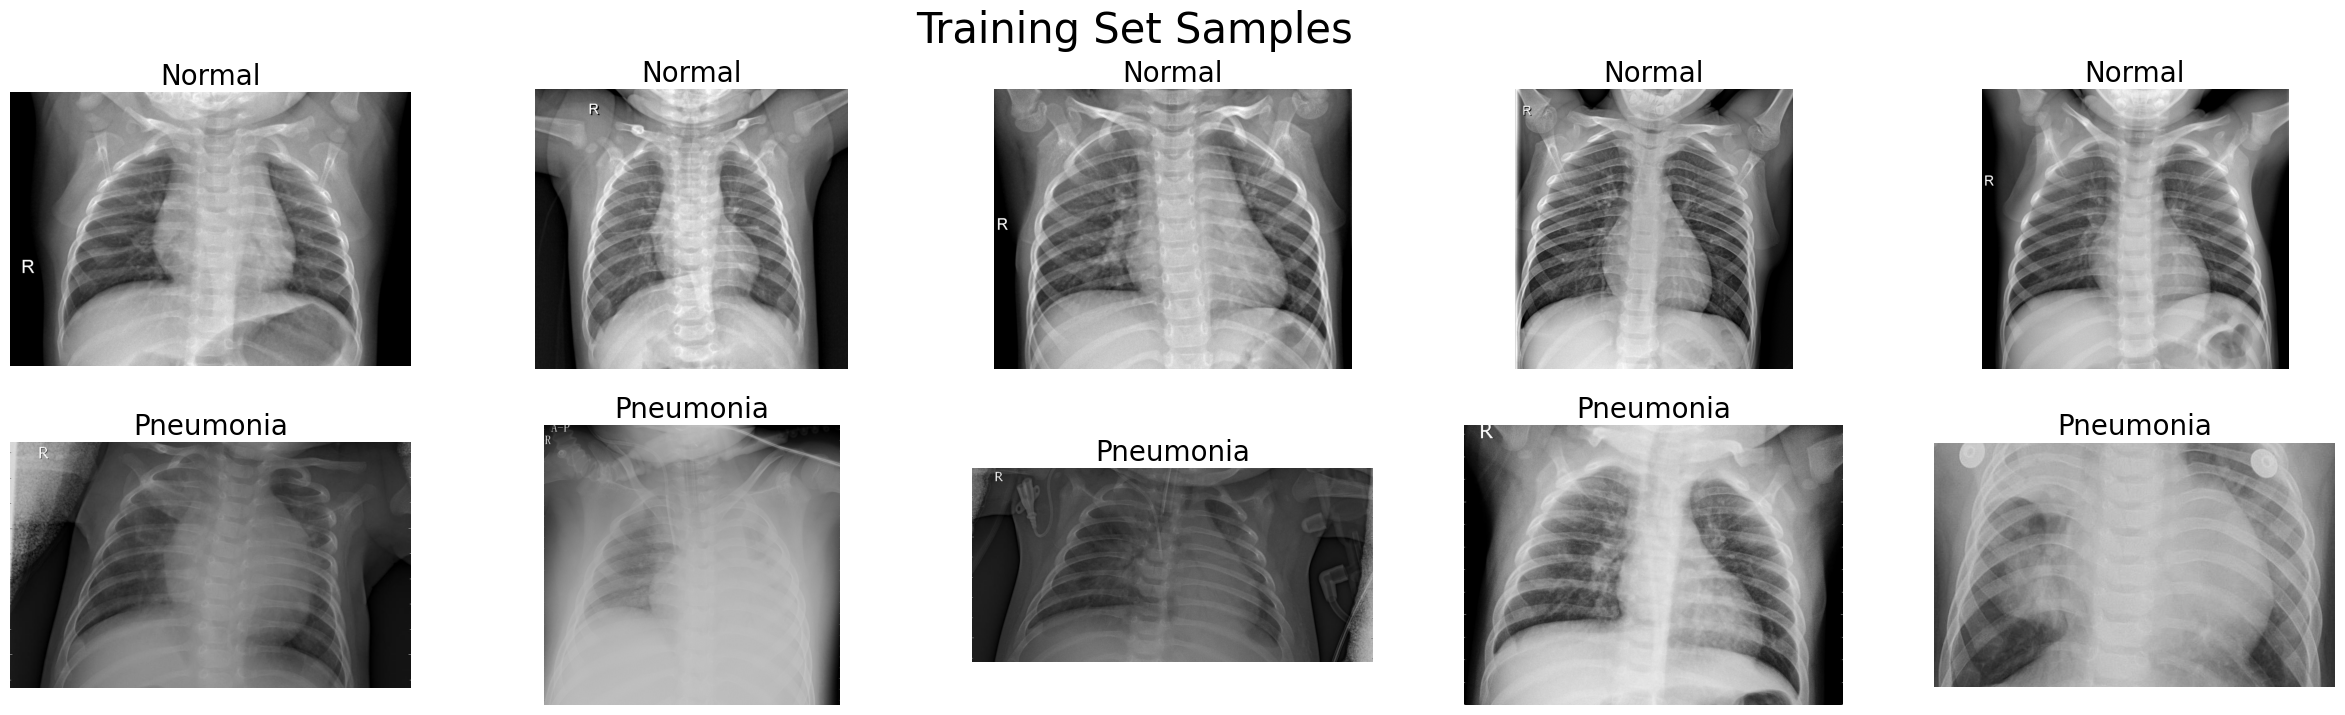

In [ ]:
#Visualising some Training samples
def plot_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,8))
    for i in range(len(samples)):
        image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)
        ax[i//5][i%5].imshow(image)
        if i<5:
            ax[i//5][i%5].set_title("Normal", fontsize=20)
        else:
            ax[i//5][i%5].set_title("Pneumonia", fontsize=20)
        ax[i//5][i%5].axis('off')

# plot_samples
rand_samples = random.sample([os.path.join(Data_path+'/train/NORMAL', filename)
                              for filename in os.listdir(Data_path+'/train/NORMAL')], 5) + \
            random.sample([os.path.join(Data_path+'/train/PNEUMONIA', filename)
                   for filename in os.listdir(Data_path+'/train/PNEUMONIA')], 5)

plot_samples(rand_samples)
plt.suptitle('Training Set Samples', fontsize=30)
plt.show()

In [ ]:
#Check the device status
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cpu')

In [ ]:
#Move tensor to device
def to_device(data, device):

    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# **Deep-Learning Model**

In [ ]:
#Define model
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        # Load pre-trained ResNet model
        self.pre_model = models.resnet18(pretrained=True)
        # Freeze the pre-trained layers
        for param in self.pre_model.parameters():
            param.requires_grad = False

        # Replace the fully connected layer
        self.pre_model.fc = nn.Linear(self.pre_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.pre_model(x)

# Define the number of classes
num_classes = len(class_names)

model = ResNet18(num_classes)
print(model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 107MB/s]


ResNet18(
  (pre_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

# **Training and Fine-Tuning Model**

In [ ]:
# Training function for the model
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    # Save the initial model weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists to store accuracy and loss values
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    # Loop over the number of epochs
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        print("="*10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.2f}'.format(phase, epoch_loss, epoch_acc))


            # Save accuracy and loss values
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

            # Deep copy the model if we have a new best validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best Validation Accuracy: {:.2f}%'.format(best_acc * 100))


    # Plot accuracy and loss curves
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc_history, label='Train')
    plt.plot(val_acc_history, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_loss_history, label='Train')
    plt.plot(val_loss_history, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()

    # Load best model weights and return the model
    model.load_state_dict(best_model_wts)
    return model




In [ ]:
#save the model path
save_path = '/content/drive/MyDrive/chest_xray.pth'
torch.save(model.state_dict(), save_path)

In [ ]:
#Initialzing model, Loss Function, Optimizer and Scheduler
model = ResNet18(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1/10


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.2970 Acc: 0.88
val Loss: 0.8605 Acc: 0.50
Epoch: 2/10
train Loss: 0.1827 Acc: 0.93
val Loss: 0.4851 Acc: 0.69
Epoch: 3/10
train Loss: 0.1572 Acc: 0.94
val Loss: 0.4277 Acc: 0.75
Epoch: 4/10
train Loss: 0.1355 Acc: 0.95
val Loss: 0.3325 Acc: 0.81
Epoch: 5/10
train Loss: 0.1302 Acc: 0.95
val Loss: 0.3862 Acc: 0.81
Epoch: 6/10
train Loss: 0.1254 Acc: 0.95
val Loss: 0.5457 Acc: 0.62
Epoch: 7/10
train Loss: 0.1203 Acc: 0.95
val Loss: 0.3182 Acc: 0.88
Epoch: 8/10
train Loss: 0.1171 Acc: 0.96
val Loss: 0.3436 Acc: 0.81
Epoch: 9/10
train Loss: 0.1151 Acc: 0.96
val Loss: 0.3603 Acc: 0.81
Epoch: 10/10
train Loss: 0.1129 Acc: 0.96
val Loss: 0.3784 Acc: 0.81
Best Validation Accuracy: 87.50%


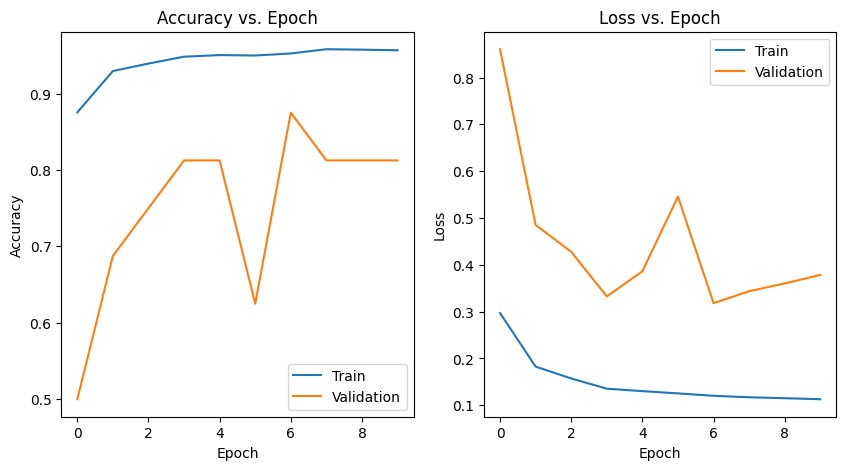

In [ ]:
model = train_model(model, criterion, optimizer, scheduler,num_epochs=10)

In [ ]:
#save the model path
save_path = '/content/drive/MyDrive/chest_xray.pth'
torch.save(model.state_dict(), save_path)

# **Evaluating the Model Using New Data**

No. of training examples for Pneumonia: 390
No. of training examples for Normal: 234


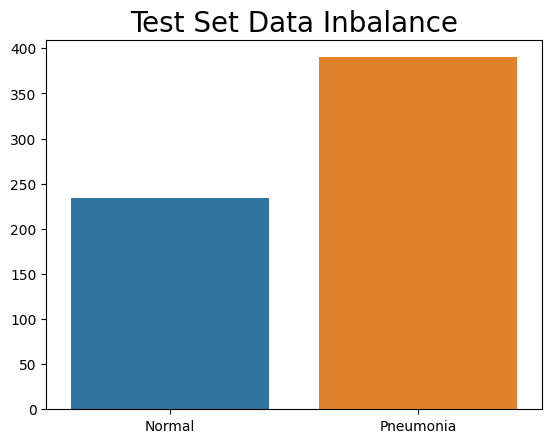

In [ ]:
#Load test Dataset
test_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(Data_path+'/test/NORMAL', filename)
                     for filename in os.listdir(Data_path+'/test/NORMAL')])],
     'Pneumonia': [len([os.path.join(Data_path+'/test/PNEUMONIA', filename)
                        for filename in os.listdir(Data_path+'/test/PNEUMONIA')])]})

#Number of test samples
pneumonia_files = os.listdir(Data_path + "/test/PNEUMONIA")
normal_files = os.listdir(Data_path + "/test/NORMAL")
print('No. of training examples for Pneumonia:', len(pneumonia_files))
print('No. of training examples for Normal:', len(normal_files))

#plot test set data
sns.barplot(data=test_samplesize).set_title('Test Set Data Inbalance', fontsize=20)
plt.show()

In [ ]:
#Test predict Function

@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [model.validation_step(batch) for batch in test_loader]
    results = model.test_prediction(outputs)
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))

    return results['test_preds'], results['test_labels']

In [ ]:
dataloaders = { TEST: torch.utils.data.DataLoader(image_datasets[TEST], batch_size =1, shuffle=True)}

In [ ]:
def test_model():
    # Initialize counters
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    input_images = []

    # No need to track gradients for testing
    with torch.no_grad():
        # Iterate over test data
        for data in dataloaders[TEST]:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Store true labels
            true_labels.append(labels.item())

            #Store model input images
            input_images.append(inputs)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)

            # Store predicted labels
            pred_labels.append(preds.item())

            # Update counters
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()

        # Calculate accuracy
        acc = running_correct / running_total

    return true_labels, pred_labels, input_images,  running_correct, running_total, acc

In [ ]:
true_labels, pred_labels, input_images, running_correct, running_total, acc = test_model()

In [ ]:
#Test Accuracy
print("Test Accuracy:% ", acc * 100)


Test Accuracy:%  81.41025641025641


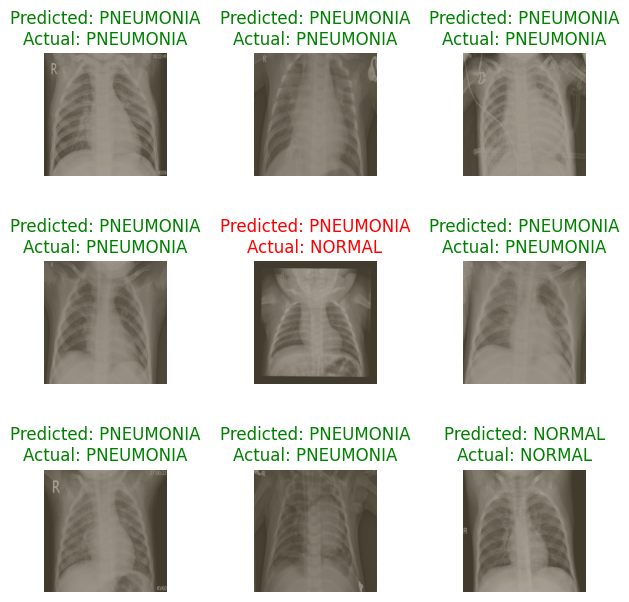

In [ ]:
# Plot Predictions against Actual Labels
fig, axes = plt.subplots(3,3, figsize=(7, 7))
fig.subplots_adjust(hspace=0.7, wspace=0.7)
x=0
for i in range(3):
    for j in range(3):
        # Get the image and labels
        inp = input_images[x].squeeze()

        true_label = true_labels[x]
        pred_label = pred_labels[x]

        # Normalize the image for display
        inp = inp.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

        # Display the image
        axes[i, j].imshow(inp)

        # Set the title with the predicted and actual labels
        title = "Predicted: {}\nActual: {}".format(class_names[pred_label], class_names[true_label])
        color = 'green' if pred_label == true_label else 'red'
        axes[i, j].set_title(title, color=color)

        # Hide the axes
        axes[i, j].axis('off')

        # Move to the next image
        x += 1

plt.show()

# **Compute Performance Metrics**

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision
precision = precision_score(true_labels, pred_labels, average='weighted')

# Calculate recall
recall = recall_score(true_labels, pred_labels, average='weighted')

# Calculate F1 score
f1 = f1_score(true_labels, pred_labels, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Precision: 0.8398568382576912
Recall: 0.8141025641025641
F1 Score: 0.7994071146245059


<Figure size 640x480 with 0 Axes>

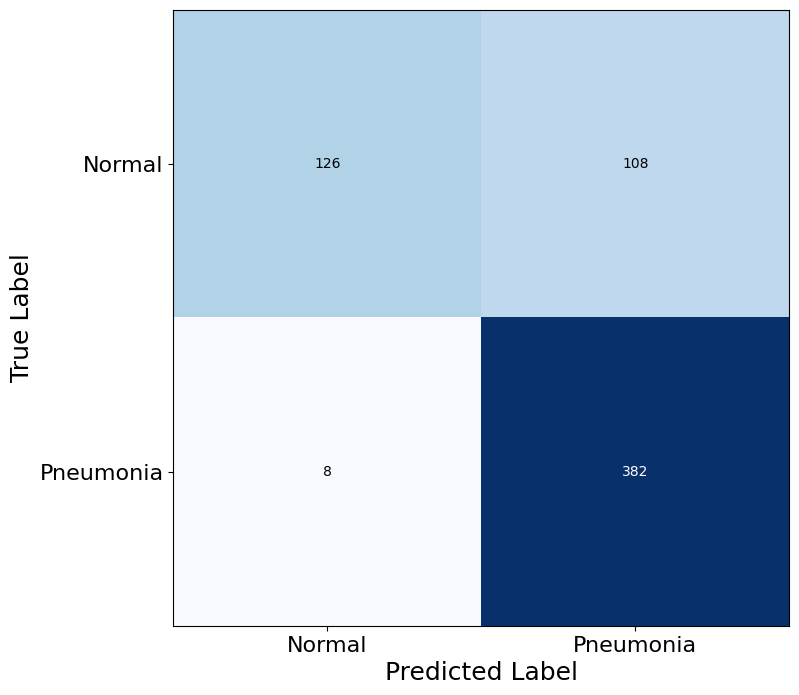

In [ ]:
# Plot confusion matrix
cm  = confusion_matrix(true_labels, pred_labels)
plt.figure()
plot_confusion_matrix(cm,figsize=(8,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()